# Sensitivity to outliers

In this task we are supposed to split “MNIST” dataset to 10 random disjoint subsets, each for one worker, and consider SVM classifier in the form of $min_w\frac{1}{N}\sum_{i\in[N]}f_i(w)$ with $N = 10$. Consider the following outlier model: each worker $i$ at every iteration independently and randomly with probability $p$ adds a zero-mean Gaussian noise with a large variance $R$ to the information it shares, i.e., $\nabla f_i$ and $w_{j,k}$ in the cases of Algorithm 1 and decentralized subgradient method respectively.

Part 1-1: Characterize the convergence against p and R?
For this part, we have used 10 “Threads” in order to emulate workers and run the algorithm in a decentralilzed manner.
Then, after running the decentralized algorithm, we plot the “total loss” versus “number of iteration” for different amount of probability and variance. The amount of allowable loss is set to 50. As it can be seen, the amount of loss converges for different values of probability and variance. The following plots show the loss versus iteration for ten workers.

<img src="img/CA4-master_loss.png" width="400">

Part 1-2:
Propose an efficient approach to improve the robustness of Algorithm 1?
In this case, the proposed approach is that the master updates the gradient with regard to w_k for each class using weighted average on how similar the w_ks of a worker are to the rest of workers. We used cosine operator for similarity. The following figures show the results of running rubust decentralized gradient descent algorithm.

we propuse to trasmit workers' message to master multiple times (e.g 10) therefore the master can average the received gradients from each worker, resulting in a more accurate gradients and then perform the update on $w_k$.

<img src="img/master_loss_r.png" width="400">

As it can be seen through above figures, the algorithm is more robust to noise.

part 2-1:
Consider a two-star topology with communication graph (1,2,3,4)-5-6-(7,8,9,10) and run decentralized subgradient method. The following figure shows the topology of network. 

<img src="img/topology.png" width="400">

Part 2-1:
In this part we calculated the average by using the formulation of average consensus problem. As it can be seen in the following plots, the total loss converges to a fixed amount for different values of probability and variance. in robust method we increase the communication in order to have multiple instance of noisy gradients from each worker.
averaging these instances results in more accurate gradient estimate compared to one individual transmission. therefore the overall algorithm will be more robust to outliers. 

<img src="img/star1.png" width="400">
<img src="img/star2.png" width="400">
<img src="img/star3.png" width="400">

Part 2-2:
in robust method we increase the communication in order to have multiple instance of noisy gradients from each worker.
averaging these instances results in more accurate gradient estimate compared to one individual transmission. therefore the overall algorithm will be more robust to outliers. The following plots show the results of rubust algorithm.
<img src="img/star_r_1.png" width="400">
<img src="img/star_r_2.png" width="400">
<img src="img/star_r_3.png" width="400">

Part 3:
In Algorithm 1 that we have a master node, obviously the master node should be protected. In addition, 2 other nodes that are more similar to the rest of the nodes should be protected. In other words, 2 nodes that have more weight should be protected.
In the two-star topology, nodes 5 and 6 that are star nodes should be protected, and also another node can be chosen.

In addition, for calculating the average in robust method we should assign more weight to the nodes that are protected.

In [1]:
#Our code is based on multiclass svm. We compute class scores for each sample $x_i$ using $Wx_i + b$ where $b$ is the bias and each row of $W$ is a classifier for one of the labels $j$. For simplicity we combine $b$ with $W$ and extend the vectors x_i with one additional dimension that always holds the constant 0.01. The loss function for $x_i$ is computed using $L_i = \sum_{j \neq y_i} \max(0, (w_j - w_{y_i})^T x + \delta)$ a (Wx_i + b). We minimize the average loss using decentralized gradient descent and distributed subgradient method.
import numpy as np
a_k = .5
lambda_ = 1
delta = 0
ps = np.linspace(0, 1., 3)
Rs = np.linspace(0, 50., 3)
epsilon = 1e-4
sample_num = 60000
max_iter = 100


mnist_dataset = np.load("./mnist.npz")

#reshape x_train and x_test into matrices [x1|x2|....|xM]
M, D1, D2 = mnist_dataset['x_train'].shape
x_train = mnist_dataset['x_train'].reshape(M, D1 * D2).T
x_train = np.vstack([x_train, np.ones((1, M))])
x_train = (x_train / np.linalg.norm(x_train, axis = 0))[:,:sample_num]
y_train = mnist_dataset['y_train'].reshape(M, 1).astype(int)[:sample_num]

M_test, D1, D2 = mnist_dataset['x_test'].shape
x_test = mnist_dataset['x_test'].reshape(M_test, D1 * D2).T
x_test = np.vstack([x_test, np.ones((1, M_test))])
x_test = (x_test / np.linalg.norm(x_test, axis = 0))[:,:sample_num]
y_test = mnist_dataset['y_test'].reshape(M_test, 1).astype(int)[:sample_num]


In [2]:
def nmae(y,yhat):
    y = np.array(y).reshape(y.shape[0],1)
    yhat = np.array(yhat).reshape(yhat.shape[0],1)
    result = np.sum(y != yhat).astype(float)/(y.shape[0])
    return result

In [3]:
#Split dataset to 10 partitions
workers_x = np.split(x_train, (np.arange(1, 10) * .1 * x_train.shape[1]).astype(int), axis = 1)
workers_y = np.split(np.array(y_train), (np.arange(1, 10) * .1 * x_train.shape[1]).astype(int), axis = 0)

#SVM binary classification loss and its gradient
def get_j_mask(y):
    j_mask = np.ones((y.shape[0], 10))
    j_mask[np.arange(0, y.shape[0]), y.reshape(y.shape[0])] = 0
    j_mask_not = np.ones(j_mask.shape) - j_mask
    return j_mask, j_mask_not

def SVM_classify(x, w):
    return np.argmax(np.matmul(x.T, w), axis = 1).reshape(x.shape[1], 1)

def SVM_cost(x, y, w, j_mask):
    return np.multiply(j_mask, (np.matmul(x.T, w) - np.repeat(np.multiply(x.T, w[:,y.reshape(y.shape[0])].T).sum(axis = 1).reshape(y.shape[0], 1), 10, axis = 1) + delta).clip(min = 0))

def regulated_total_cost(x, y, w, lambda_, j_mask):
    return SVM_cost(x, y, w, j_mask).sum() + lambda_/2 * np.linalg.norm(w)**2

def SVM_cost_grad(x, y, w, lambda_, j_mask, j_mask_not):
    svm_cost = SVM_cost(x, y, w, j_mask) > 0
    x_rp = np.repeat(x.T, 10, axis = 0).reshape(x.shape[1], 10*x.shape[0])
    return (np.multiply(np.repeat(svm_cost - np.multiply(np.repeat(svm_cost.sum(axis=1).reshape(svm_cost.shape[0], 1), 10, axis=1), j_mask_not), x.shape[0], axis=1), x_rp).sum(axis=0).reshape(10, x.shape[0]).T)

In [4]:
def gd_backtracking(w_k, a_k, grad_w, x, y, lambda_, j_mask):
    a = a_k
    w_k_1 = w_k - a * grad_w
    #while(regulated_total_cost(x, y, w_k_1, lambda_, j_mask) >= regulated_total_cost(x, y, w_k, lambda_, j_mask)):
    #    a /= 2
    #    w_k_1 = w_k - a * grad_w
    return w_k_1


def gradient_descent(x, y, lambda_, a_k):
    j_mask, j_mask_not = get_j_mask(y_train)
    w_k = np.random.rand((x.shape[0] * 10)).reshape(x.shape[0],10)
    k = 0
    L1 = regulated_total_cost(x, y, w_k, lambda_, j_mask)
    while True:
        L = L1
        k += 1
        grad_w = SVM_cost_grad(x, y, w_k, lambda_, j_mask, j_mask_not)
        w_k = gd_backtracking(w_k, a_k, grad_w, x, y, lambda_, j_mask)
        L1 = regulated_total_cost(x, y, w_k, lambda_, j_mask)
        print(k, L1, np.linalg.norm(grad_w))
        if np.abs(L-L1) < epsilon or k == max_iter:
        #if np.linalg.norm(grad_w) < epsilon:
            break
    return w_k.reshape(x.shape[0],10)

#w_k = gradient_descent(x_train, y_train, lambda_, a_k)

#y_predict = SVM_classify(x_train, w_k)
#print(nmae(y_train, y_predict))
#y_predict = SVM_classify(x_test, w_k)
#print(nmae(y_test, y_predict))


In [5]:
#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with probability p
def decentralized_gradient_descent_worker(x, y, w_k, lambda_, j_mask, j_mask_not, p, R):
    grad_w = SVM_cost_grad(x, y, w_k, lambda_, j_mask, j_mask_not)
    noise_mask = np.random.rand(1) < p
    return np.array(grad_w) + noise_mask * np.random.normal(0, R, grad_w.size).reshape(grad_w.shape)

#Master updates the gradient w.r.t w_k for each class
def decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_, j_mask):
    w_k = gd_backtracking(w_k, a_k, grad_w.mean(axis = 0).reshape(w_k.shape), x, y, lambda_, j_mask)
    return w_k

In [6]:
from multiprocessing.pool import ThreadPool

def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)


#algorithm 1
def decentralized_gradient_descent(x, y, workers_x, workers_y, lambda_, a_k, p, R, master, worker_):
    j_mask = range(10)
    j_mask_not = range(10)
    for i in range(10):
        j_mask[i], j_mask_not[i] = get_j_mask(workers_y[i])
    j_mask_all, j_mask_not_ll = get_j_mask(y)
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    k = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_, j_mask_all)
    while True:
        L = L1
        k += 1
        #copy w_k of classes for workers
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        #each worker gets a copy of w_ks for 10 classes, and its part of features and adjusted labels and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_], j_mask, j_mask_not, 10 * [p], 10 * [R])
        #results = []
        #for i in range(10):
        #    results.append(decentralized_gradient_descent_worker(*zipped[i]))
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        grad_w = np.array(results)
        #master updates w_ks
        w_k = master(w_k, a_k, grad_w, x, y, lambda_, j_mask_all)
        L1 = regulated_total_cost(x, y, w_k, lambda_, j_mask_all)
        errs.append((k, L1))
        #print(k, L1, np.linalg.norm(grad_w))
        if np.abs(L-L1) < epsilon or k == max_iter:
            break
    print(k, L1, np.linalg.norm(grad_w))
    return w_k.reshape(x.shape[0],10), k, errs


In [7]:
def get_iteration_number_vs_p_and_R(algorithm, ps, Rs, **kwargs):
    d = []
    for R in Rs:
        for p in ps:
            kwargs['p'] = p
            kwargs['R'] = R
            print p, R
            w_k, k, errs = algorithm(**kwargs)
            d.append((w_k, k, errs, p, R))
    return d

kwargs = {'x':x_train, 'y':y_train, 'workers_x':workers_x, 'workers_y':workers_y, 'lambda_':lambda_, 'a_k':a_k, 'master':decentralized_gradient_descent_master, 'worker_':decentralized_gradient_descent_worker_}
dgd_dps = get_iteration_number_vs_p_and_R(decentralized_gradient_descent, ps, [Rs[1]], **kwargs)
dgd_dRs = get_iteration_number_vs_p_and_R(decentralized_gradient_descent, [ps[1]], Rs, **kwargs)


0.0 25.0
(100, 1.6139602973942466, 3.56775219352573)
0.5 25.0
(100, 9487.318471964561, 4964.691718286464)
1.0 25.0
(100, 17296.155458449546, 7008.482982616963)
0.5 0.0
(100, 1.8017894096122458, 3.959695529482603)
0.5 25.0
(100, 8984.52223499359, 5447.617170622818)
0.5 50.0
(100, 33799.24938341989, 11706.059973155587)


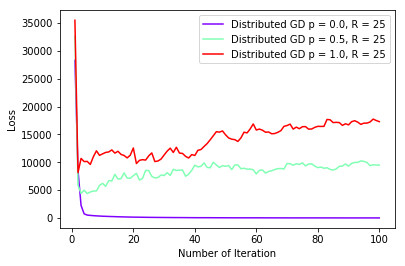

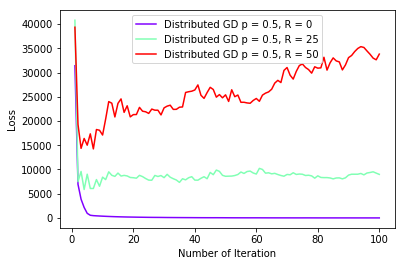

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline


colors = iter(cm.rainbow(np.linspace(0, 1, len(dgd_dps))))
legends = []
for i in range(len(dgd_dps)):
    w_k, k, errs, p, R = dgd_dps[i]
    k, loss = zip(*errs)
    plt.plot(k, loss, color=next(colors))
    plt.xlabel("Number of Iteration")
    plt.ylabel("Loss")
    legends.append('Distributed GD p = %.1f, R = %d' %(p,R))
plt.legend(legends)
plt.show()

colors = iter(cm.rainbow(np.linspace(0, 1, len(dgd_dRs))))
legends = []
for i in range(len(dgd_dRs)):
    w_k, k, errs, p, R = dgd_dRs[i]
    k, loss = zip(*errs)
    plt.plot(k, loss, color=next(colors))
    legends.append('Distributed GD p = %.1f, R = %d' %(p,R))
    plt.xlabel("Number of Iteration")
    plt.ylabel("Loss")
plt.legend(legends)
plt.show()

#ks = []
#w_ks = []
#errss = []
#for i in range(1):
#    w_k, k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, ps[0], Rs[0], decentralized_gradient_descent_master)
#    print "iterations : %d"%k
#    ks.append(k)
#    w_ks.append(w_k)
#    errss.append(errs)

#w_k = np.array(w_ks).mean(axis = 0)
#k = np.array(ks).mean()
#errs = np.array(errss).mean(axis = 0)
#print "iterations : %d"%k



#y_predict = SVM_classify(x_train, w_k)
#print(nmae(y_train, y_predict))
#y_predict = SVM_classify(x_test, w_k)
#print(nmae(y_test, y_predict))


In [25]:
from scipy.spatial.distance import cdist

#algorithm 1 robusted version
#Robust master updates the gradient w.r.t w_k for each class using weighted average on how similar the w_ks of a worker are to the rest of workers. we used cosine operator for similarity
def robust_decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_, j_mask):
    grad_w = grad_w.reshape(10, w_k.size)
    worker_weights = cdist(grad_w, grad_w,'cosine').sum(axis = 0).reshape(10, 1)
    worker_weights[np.isnan(worker_weights)] = 1.
    worker_weights += 1
    worker_weights /= np.linalg.norm(worker_weights)
    w_k = gd_backtracking(w_k, a_k, np.multiply(np.array(worker_weights).reshape(10, 1), grad_w).reshape(10, w_k.shape[0], 10).sum(axis = 0).reshape(w_k.shape), x, y, lambda_, j_mask)
    return w_k

#algorithm 1 robusted version
#Robust worker sends C = 10 messages => the noise is averaged
def robust_decentralized_gradient_descent_worker(x, y, w_k, lambda_, j_mask, j_mask_not, p, R):
    grad_w = SVM_cost_grad(x, y, w_k, lambda_, j_mask, j_mask_not)
    noise = np.zeros(grad_w.shape)
    for i in range(10):
        noise_mask = np.random.rand(1) < p
        noise += noise_mask * np.random.normal(0, R, grad_w.size).reshape(grad_w.shape)
    return np.array(grad_w) + noise / 10

def robust_decentralized_gradient_descent_worker_(args):
    return robust_decentralized_gradient_descent_worker(*args)

In [26]:
kwargs = {'x':x_train, 'y':y_train, 'workers_x':workers_x, 'workers_y':workers_y, 'lambda_':lambda_, 'a_k':a_k, 'master':decentralized_gradient_descent_master, 'worker_':robust_decentralized_gradient_descent_worker_}
rdgd_dps = get_iteration_number_vs_p_and_R(decentralized_gradient_descent, ps, [Rs[1]], **kwargs)
rdgd_dRs = get_iteration_number_vs_p_and_R(decentralized_gradient_descent, [ps[1]], Rs, **kwargs)


#ks = []
#w_ks = []
#errss = []
#for i in range(1):
#    w_k, k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, ps[0], Rs[0], robust_decentralized_gradient_descent_master)
#    print "iterations : %d"%k
#    ks.append(k)
#    w_ks.append(w_k)
#    errss.append(errs)
    
#w_k = np.array(w_ks).mean(axis = 0)
#k = np.array(ks).mean()
#errs = np.array(errss).mean(axis = 0)
#print "iterations : %d"%k

#y_predict = SVM_classify(x_train, w_k)
#print(nmae(y_train, y_predict))
#y_predict = SVM_classify(x_test, w_k)
#print(nmae(y_test, y_predict))


0.0 25.0
(100, 6.572151976637484, 11.012420351652501)
0.5 25.0
(100, 1236.2657312533224, 1663.6901822388938)
1.0 25.0
(100, 2582.542928549077, 2210.060266313654)
0.5 0.0
(100, 3.8094437488581434, 4.859500693430987)
0.5 25.0
(100, 1083.671109130331, 1603.0167959971097)
0.5 50.0
(100, 4109.392182881423, 3297.745830916292)


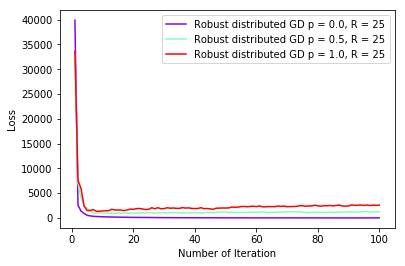

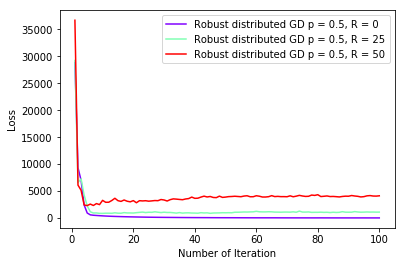

In [64]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

colors = iter(cm.rainbow(np.linspace(0, 1, len(rdgd_dps))))
legends = []
for i in range(len(rdgd_dps)):
    w_k, k, errs, p, R = rdgd_dps[i]
    k, loss = zip(*errs)
    plt.plot(k, loss, color=next(colors))
    plt.xlabel("Number of Iteration")
    plt.ylabel("Loss")
    legends.append('Robust distributed GD p = %.1f, R = %d' %(p,R))
plt.legend(legends)
plt.show()

colors = iter(cm.rainbow(np.linspace(0, 1, len(rdgd_dRs))))
legends = []
for i in range(len(rdgd_dRs)):
    w_k, k, errs, p, R = rdgd_dRs[i]
    k, loss = zip(*errs)
    plt.plot(k, loss, color=next(colors))
    legends.append('Robust distributed GD p = %.1f, R = %d' %(p,R))
    plt.xlabel("Number of Iteration")
    plt.ylabel("Loss")
plt.legend(legends)
plt.show()



In [57]:
A = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]])
#A = np.ones((10, 10))
A = np.repeat(np.repeat(A.reshape(10, 10, 1, 1), x_train.shape[0], axis = 2), 10, axis=3)

a_k = 1e-7
Rs = np.linspace(0, 0.02, 2)
max_iter = 100

def decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k, j_mask, j_mask_not, p, R):
    bar_w_k = np.multiply(Ai, w_k).mean(axis = 0)
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_, j_mask, j_mask_not)
    bar_w_k = gd_backtracking(bar_w_k, a_k, grad_w, x, y, lambda_, j_mask)
    noise_mask = np.random.rand(1) < p
    return bar_w_k + noise_mask * np.random.normal(0, R, bar_w_k.size).reshape(bar_w_k.shape), grad_w
    #return bar_w_k, grad_w

def decentralized_subgradient_method_agent_(args):
    return decentralized_subgradient_method_agent(*args)


def decentralized_subgradient_method(x, y, workers_x, workers_y, lambda_, a_k, A, p, R, agent):
    j_mask = range(10)
    j_mask_not = range(10)
    for i in range(10):
        j_mask[i], j_mask_not[i] = get_j_mask(workers_y[i])
    j_mask_all, j_mask_not_ll = get_j_mask(y)
    #each class has a w_k
    w_k = np.random.rand(10, x.shape[0], 10)
    k = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_, j_mask_all)
    while True:
        L = L1
        k += 1
        #copy w_k of classes for workers
        workers_w_k = np.array(10 * [w_k]).reshape(10, 10, x.shape[0], 10)
        #each worker gets a copy of w_ks for 10 classes, and its part of features and adjusted labels and returns 10 loss gradients, one per class
        zipped = zip(A, workers_x, workers_y, workers_w_k, 10 * [lambda_], 10 * [a_k], j_mask, j_mask_not, 10 * [p], 10 * [R])
        #results = []
        #for i in range(10):
        #    results.append(decentralized_subgradient_method_agent(*zipped[i]))
        pool = ThreadPool(10)
        results = pool.map(decentralized_subgradient_method_agent_, zipped)
        pool.close()
        pool.join()
        w_k, grad_w = np.array(zip(*results))
        L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_, j_mask_all)
        L1s = []
        for i in range(10):
            L1s.append(regulated_total_cost(x, y, w_k[i], lambda_, j_mask_all))
        errs.append((k, L1s))
        if np.abs(L-L1) < epsilon or k == max_iter:
            break
    print(k, L1, np.linalg.norm(grad_w.mean(axis = 0)))
    return w_k.mean(axis = 0).reshape(x.shape[0],10), k, errs



In [58]:

kwargs = {'x':x_train, 'y':y_train, 'workers_x':workers_x, 'workers_y':workers_y, 'lambda_':lambda_, 'a_k':a_k, 'A':A, 'agent':decentralized_subgradient_method_agent}
dsm_dps = get_iteration_number_vs_p_and_R(decentralized_subgradient_method, ps, [Rs[1]], **kwargs)
dsm_dRs = get_iteration_number_vs_p_and_R(decentralized_subgradient_method, [ps[1]], Rs, **kwargs)

#w_k, k, p = dsm_dps[0]

#ks = []
#w_ks = []
#errss = []
#for i in range(1):
#    w_k, k, errs = decentralized_subgradient_method(x_train, y_train, workers_x, workers_y, lambda_, a_k, A, ps[0], Rs[0], decentralized_subgradient_method_agent)
#    print "iterations : %d"%k
#    ks.append(k)
#    w_ks.append(w_k)
#    errss.append(errs)
    
#w_k = np.array(w_ks).mean(axis = 0)
#k = np.array(ks).mean()
#errs = np.array(errss).mean(axis = 0)
#print "iterations : %d"%k

#y_predict = SVM_classify(x_train, w_k)
#print(nmae(y_train, y_predict))
#y_predict = SVM_classify(x_test, w_k)
#print(nmae(y_test, y_predict))


0.0 0.02
(17, 0.006838495384044139, 112.15506138109167)
0.5 0.02
(100, 31.655060426428488, 75.48535387174599)
1.0 0.02
(100, 31.193171413492642, 76.72646324428264)
0.5 0.0
(100, 0.006624278870124682, 108.92163420490448)
0.5 0.02
(100, 22.47233150996928, 71.00085883639154)


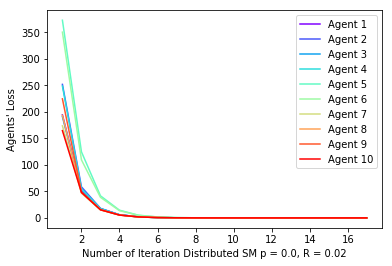

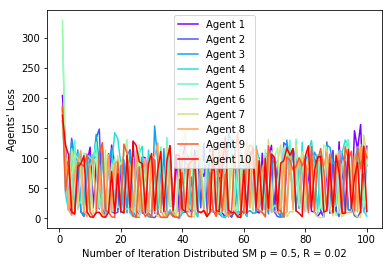

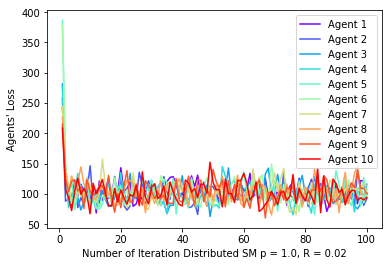

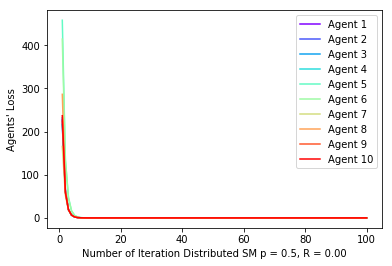

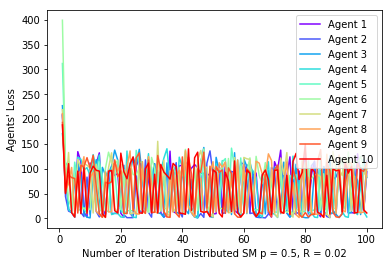

In [62]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

%matplotlib inline

for i in range(len(dsm_dps)):
    legends = []
    w_k, k, errs, p, R = dsm_dps[i]
    k, losses = zip(*errs)
    colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
    for l, j in enumerate(zip(*losses)):
        color = next(colors)
        plt.plot(k, j, color=color)    
        legends.append('Agent %d' %(l + 1))
    plt.xlabel("Number of Iteration Distributed SM p = %.1f, R = %.2f" %(p,R))
    plt.ylabel("Agents' Loss")
    plt.legend(legends)
    plt.show()
    

for i in range(len(dsm_dRs)):
    legends = []
    w_k, k, errs, p, R = dsm_dRs[i]
    k, losses = zip(*errs)
    colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
    for l, j in enumerate(zip(*losses)):
        color = next(colors)
        plt.plot(k, j, color=color)    
        legends.append('Agent %d' %(l + 1))
    plt.xlabel("Number of Iteration Distributed SM p = %.1f, R = %.2f" %(p,R))
    plt.ylabel("Agents' Loss")
    plt.legend(legends)
    plt.show()



In [66]:
def robust_decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k, j_mask, j_mask_not, p, R):
    bar_w_k = np.multiply(Ai, w_k).mean(axis = 0)
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_, j_mask, j_mask_not)
    bar_w_k = gd_backtracking(bar_w_k, a_k, grad_w, x, y, lambda_, j_mask)
    noise = np.zeros(bar_w_k.shape)
    for i in range(50):
        noise_mask = np.random.rand(1) < p
        noise += noise_mask * np.random.normal(0, R, bar_w_k.size).reshape(bar_w_k.shape)
    return bar_w_k + noise / 50, grad_w
    #return bar_w_k, grad_w

def robust_decentralized_subgradient_method_agent_(args):
    return decentralized_subgradient_method_agent(*args)

kwargs = {'x':x_train, 'y':y_train, 'workers_x':workers_x, 'workers_y':workers_y, 'lambda_':lambda_, 'a_k':a_k, 'A':A, 'agent':robust_decentralized_subgradient_method_agent}
rdsm_dps = get_iteration_number_vs_p_and_R(decentralized_subgradient_method, ps, [Rs[1]], **kwargs)
rdsm_dRs = get_iteration_number_vs_p_and_R(decentralized_subgradient_method, [ps[1]], Rs, **kwargs)


0.0 0.02
(100, 0.007067567558851469, 111.08500837771301)
0.5 0.02
(100, 20.645623538916674, 70.40258209412013)
1.0 0.02
(100, 54.520464963275536, 83.97954234751332)
0.5 0.0
(100, 0.007235355181987093, 114.78434947004189)
0.5 0.02
(100, 20.045019659959163, 78.76149956785605)


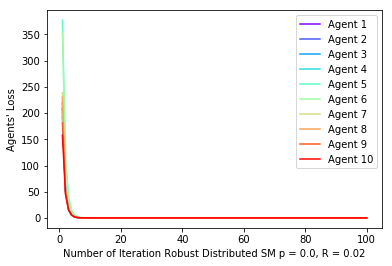

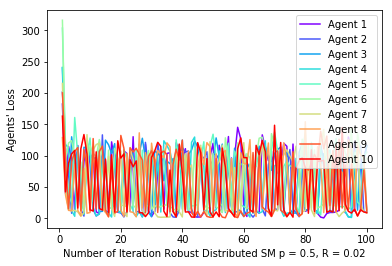

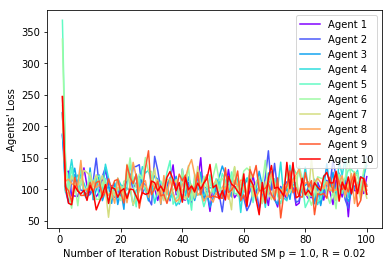

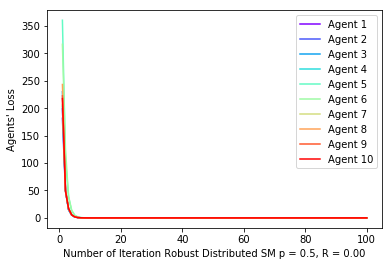

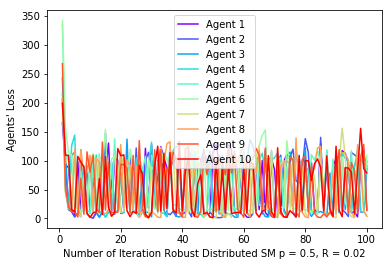

In [67]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

%matplotlib inline

for i in range(len(rdsm_dps)):
    legends = []
    w_k, k, errs, p, R = rdsm_dps[i]
    k, losses = zip(*errs)
    colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
    for l, j in enumerate(zip(*losses)):
        color = next(colors)
        plt.plot(k, j, color=color)    
        legends.append('Agent %d' %(l + 1))
    plt.xlabel("Number of Iteration Robust Distributed SM p = %.1f, R = %.2f" %(p,R))
    plt.ylabel("Agents' Loss")
    plt.legend(legends)
    plt.show()
    

for i in range(len(rdsm_dRs)):
    legends = []
    w_k, k, errs, p, R = rdsm_dRs[i]
    k, losses = zip(*errs)
    colors = iter(cm.rainbow(np.linspace(0, 1, 10)))
    for l, j in enumerate(zip(*losses)):
        color = next(colors)
        plt.plot(k, j, color=color)    
        legends.append('Agent %d' %(l + 1))
    plt.xlabel("Number of Iteration Robust Distributed SM p = %.1f, R = %.2f" %(p,R))
    plt.ylabel("Agents' Loss")
    plt.legend(legends)
    plt.show()
